In [1]:
import torch
import torchzero as tz
from visualbench import FunctionDescent, test_functions

torch.manual_seed(0)

# Gradient descent

Gradient descent is the most basic of the optimization algorithms. On each step gradient $\nabla f(x)$ is multiplied by step size $\eta$ and subtracted from parameters $x$.

$$
x \rightarrow x - \eta \nabla f(x)
$$

The step size $\eta$ can be fixed, set to a pre-determined step size schedule, or determined via a line search.

### GD with constant step size

To run GD with fixed step size, all we need to do is add the `LR` module and specify our step size.

Let's run it on
$$
f(x,y) = x^2 + y^2 + 1.99 * x * y
$$

This is badly scaled quadratic function where GD requires many iterations to converge. The gradient at initial point is large, therefore step size needs to be small to avoid overshooting. However as GD approaches the valley, gradient becomes small, and due to small step size it makes little progress.

finished in 9.2s., reached loss = 6.88e-10                                      


<Axes: >

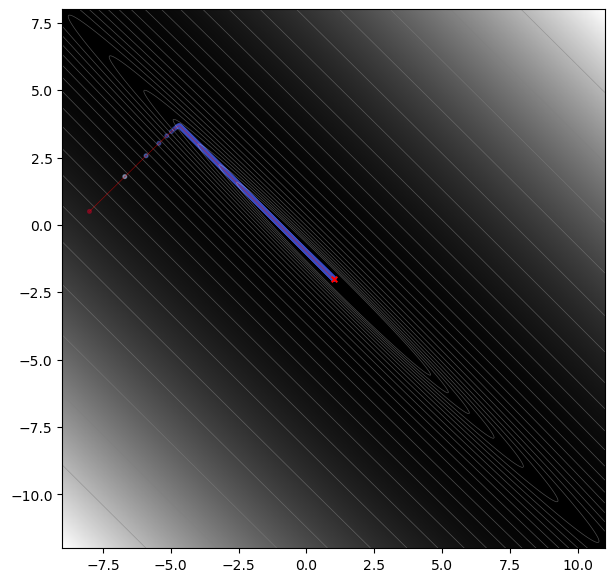

In [40]:
func = FunctionDescent('ill2')
optimizer = tz.Modular(func.parameters(), tz.m.LR(1e-1))
func.run(optimizer, max_steps=10000)
func.plot(log_contour=True)

### GD with line search
A line search tests multiple step sizes until some some criteria are satisfied. There is a whole notebook dedicated to line searches, for now let's use the StrongWolfe line search which is almost exact on a quadratic function.

The function here is 
$$
f(x) = (2*x + 3*y - 5)^2 + (5*x - 2*y - 3)^2
$$

On this function, another drawback of GD can be observed, which is the "staircase" path it takes. There is a simple modification which avoids this behaviour - the Conjugate gradient method, which will be described in a later notebook.

finished in 0.1s., reached loss = 0                                      


<Axes: >

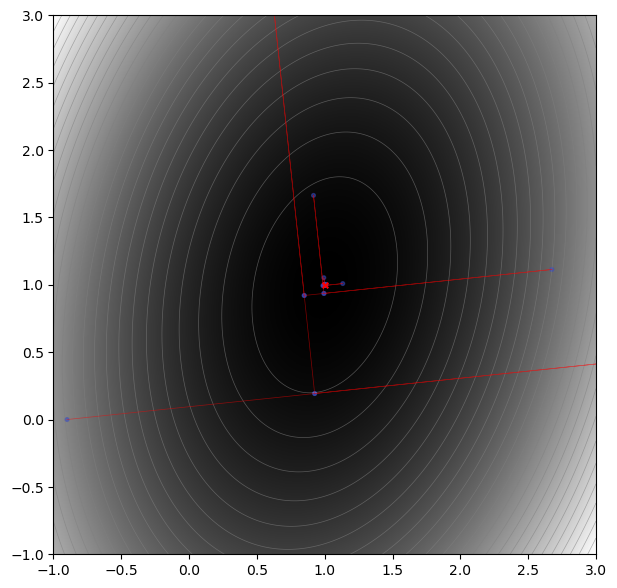

In [84]:
func = FunctionDescent('lstsq')
optimizer = tz.Modular(func.parameters(), tz.m.StrongWolfe(a_init='first-order', c2=0.1))
func.run(optimizer, max_steps=20)
func.plot()

### GD with Polyak's step size
Polyak's step size determines the step size assuming the function is convex and the objective value at the minimizer $f^*$ is known.

$$
\eta_{polyak} = \frac{f(x) - f^*} {g^T g}
$$

finished in 0.1s., reached loss = 1.06e-08                                      


<Axes: >

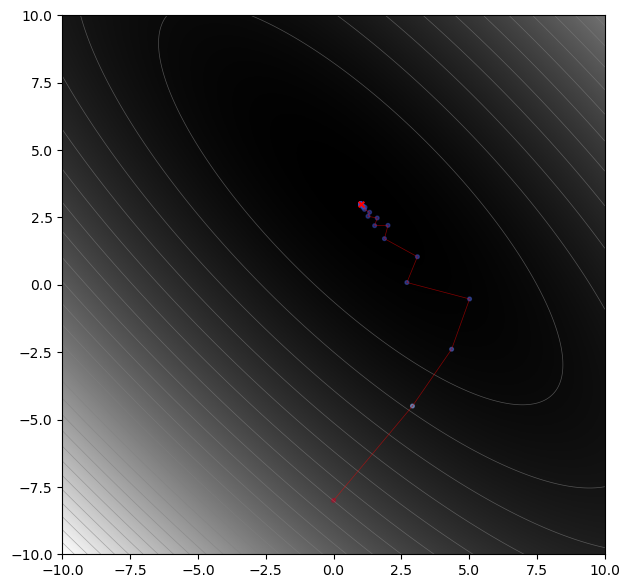

In [82]:
func = FunctionDescent('booth')
optimizer = tz.Modular(func.parameters(), tz.m.PolyakStepSize())
func.run(optimizer, max_steps=50)
func.plot()

### GD with Barzilai–Borwein step size
Barzilai–Borwein (BB) method is a way to determine the step size using a scalar approximation to the quasi-newton methods.

There are two variants of the BB - long and short.
$$
a_{long} = \frac{\Delta x^T \cdot \Delta x} {\Delta x^T \cdot \Delta g}
$$
$$
a_{short} = \frac{\Delta x^T \cdot \Delta g} {\Delta g^T \cdot \Delta g}
$$

Here $\Delta x$ is difference in parameters between previous and current step, and $\Delta g$ is difference in gradients.

Because BB uses difference in gradients, it is not suitable for stochastic optimization, but it can be used with the `tz.m.Online` and `tz.m.SVRG` modules.

Reference: *[Barzilai, Jonathan, and Jonathan M. Borwein. "Two-point step size gradient methods." IMA journal of numerical analysis 8.1 (1988): 141-148.](https://moscow.sci-hub.se/2720/4e5276c5a82d5e222fba37921001bc11/10.1093@imanum@8.1.141.pdf)*

finished in 0.0s., reached loss = 0                                      


<Axes: >

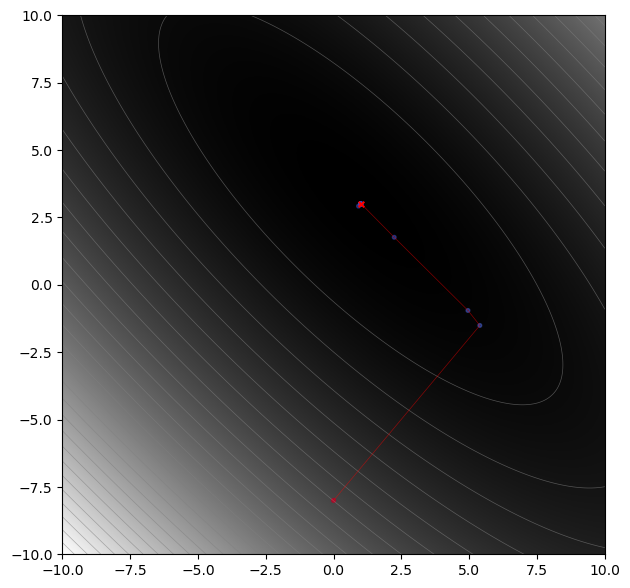

In [16]:
func = FunctionDescent('booth')
optimizer = tz.Modular(func.parameters(), tz.m.BarzilaiBorwein())
func.run(optimizer, max_steps=20)
func.plot()

# BBstab

Stabilized Barzilai-Borwein method uses the Barzilai–Borwein step-size, except the norm of the update is clipped by hyperparameter $\Delta$. The hyperparameter can be selected adaptively, where first few steps are performed without norm clipping, and delta is set to the norm of the smallest update times $c$, where $c$ is a hyperparameter can can be set to 0.2 to 0.3.

BBStab can minimize the rosenbrock function where methods above tend to require a very large number of iterations.

Reference: *[Burdakov, Oleg, Yuhong Dai, and Na Huang. "Stabilized barzilai-borwein method." Journal of Computational Mathematics (2019): 916-936.](https://arxiv.org/abs/1907.06409)*

finished in 0.6s., reached loss = 1.55e-07                                      


<Axes: >

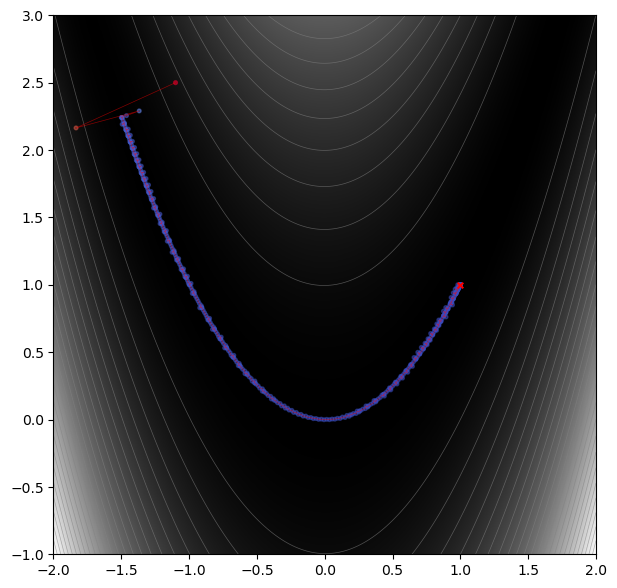

In [13]:
func = FunctionDescent('rosen')
optimizer = tz.Modular(func.parameters(), tz.m.BBStab())
func.run(optimizer, max_steps=500)
func.plot()

# AdGD and AdGD-2

Adaptive gradient descent (AdGD) and Adaptive gradient descent-2 (AdGD-2) are completely tuning-free step size methods. Here is the update rule from the paper:

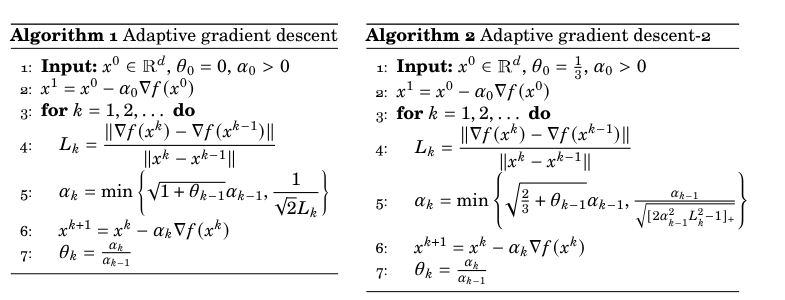

AdGDs also use difference in gradients, so they aren't suitable for stochastic optimization without `tz.m.Online` or `tz.m.SVRG`.

Reference: *[Malitsky, Yura, and Konstantin Mishchenko. "Adaptive proximal gradient method for convex optimization." Advances in Neural Information Processing Systems 37 (2024): 100670-100697.](https://arxiv.org/abs/2308.02261)*

finished in 2.3s., reached loss = 0.000282                                      


<Axes: >

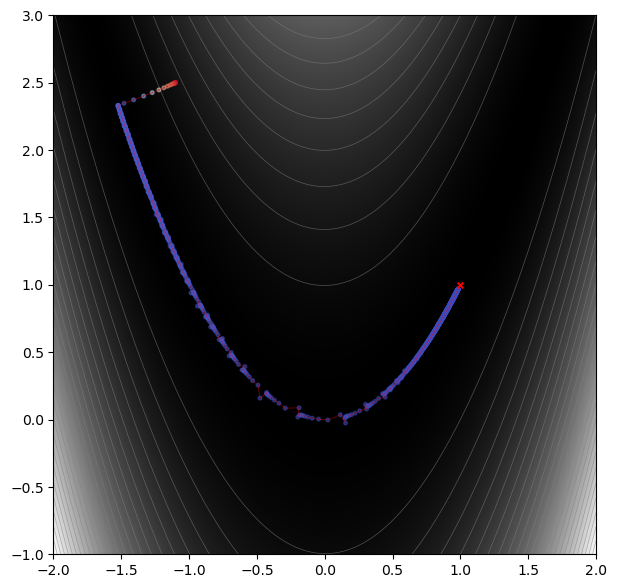

In [26]:
func = FunctionDescent('rosen')
optimizer = tz.Modular(func.parameters(), tz.m.AdGD(variant=2))
func.run(optimizer, max_steps=2000)
func.plot()

### GD with trust region
Another way to determine the step size is by using a trust region. Again, there is a whole notebook dedicated to trust regions with explaination fo what they do. Trust regions typically require hessian or approximation, but it is possible to assume hessian to be identity matrix by passing `hess_module=Identity()`, or use the `BarzilaiBorwein` scalar approximation.

The `TrustCG` module, despite having `CG` in its name, will use exact solution if it can be calculated efficiently, which it can be in our case.

finished in 5.2s., reached loss = 0.00685                                      


<Axes: >

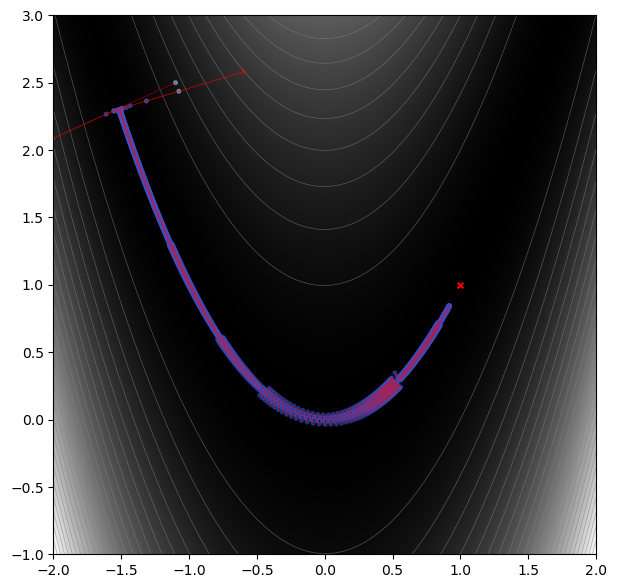

In [35]:
func = FunctionDescent('rosen')
optimizer = tz.Modular(func.parameters(), tz.m.TrustCG(hess_module=tz.m.Identity(), nplus=2, nminus=0.5))
func.run(optimizer, max_steps=2000)
func.plot()

### BB with trust region

BB can also be used with trust region, usually outperforming identity approximation.

finished in 2.7s., reached loss = 0.000352                                      


<Axes: >

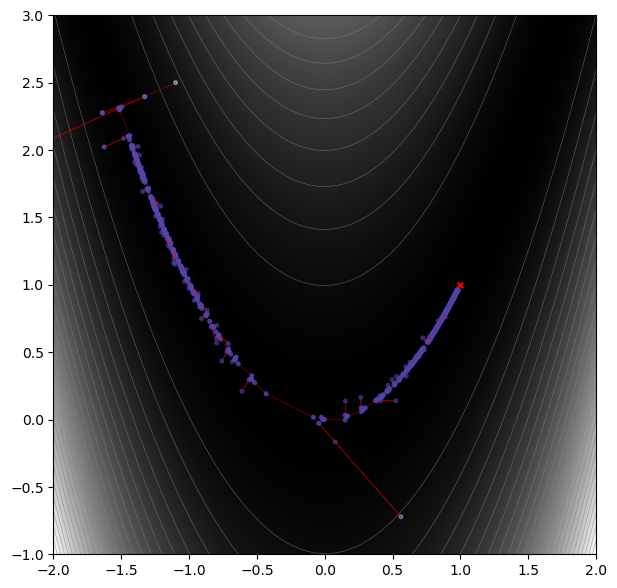

In [30]:
func = FunctionDescent('rosen')
optimizer = tz.Modular(func.parameters(), tz.m.TrustCG(tz.m.BarzilaiBorwein()))
func.run(optimizer, max_steps=1000)
func.plot()

### Normalized GD

Normalized GD is a simple modification to GD where the gradient is normalized to have unit norm.

$$
x \rightarrow x - \eta \frac{\nabla f(x)}{|| \nabla f(x) ||_2}
$$

finished in 0.2s., reached loss = 0.0123                                      


<Axes: >

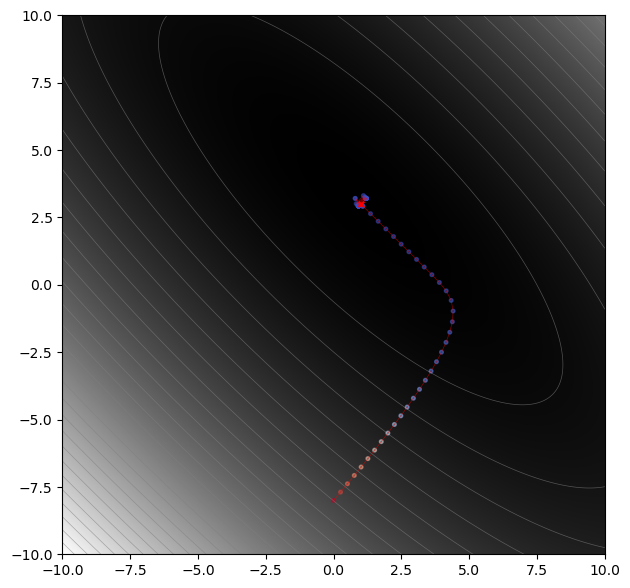

In [80]:
func = FunctionDescent('booth')
optimizer = tz.Modular(func.parameters(), tz.m.Normalize(), tz.m.LR(4e-1))
func.run(optimizer, max_steps=100)
func.plot()

### SignGD

SignGD updates parameters with sign of the gradient. It was originally suggested for distributed optimization since it compresses gradient information to just the sign, however it can also outperform GD in some cases due to inherent normalization.

$$
x \rightarrow x - \eta \text{ sign}(\nabla f(x))

finished in 0.1s., reached loss = 0.08                                      


<Axes: >

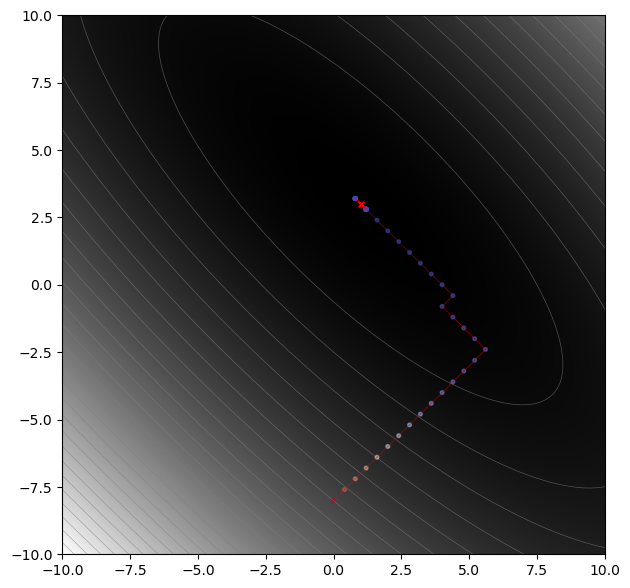

In [81]:
func = FunctionDescent('booth')
optimizer = tz.Modular(func.parameters(), tz.m.Sign(), tz.m.LR(4e-1))
func.run(optimizer, max_steps=100)
func.plot()